In [2]:
import xgboost as xg
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [3]:
# Read training data and assign last statement flag
df_train_x = pd.read_parquet('./data/train.parquet')
df_train_x.columns = df_train_x.columns.str.lower()

df_train_y = pd.read_csv('./data/train_labels.csv')
df_train_y.columns = df_train_y.columns.str.lower()

In [4]:
print(f'The shape of descriptive features :{df_train_x.shape}')
print(f'The shape of target features with customer_id :{df_train_y.shape}')

The shape of descriptive features :(5531451, 190)
The shape of target features with customer_id :(458913, 2)


In [5]:
df_train = df_train_x.set_index('customer_id').join(df_train_y.set_index('customer_id'), how = 'left',sort=True).reset_index()
df_train.head(15)

,customer_id,s_2,p_2,d_39,b_1,b_2,r_1,s_3,d_41,b_3,...,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,0,0,0.0,NaN,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,0,0,0.0,NaN,0,0.008126,0,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0,0.007863,1.005006,0.004220,0.110946,0.0,0.009866,...,-1,-1,0,0,0.0,NaN,0,0.002223,0,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0,0.018859,1.008024,0.004509,0.103329,0.0,0.000783,...,-1,-1,0,0,0.0,NaN,0,0.007661,0,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0,0.014324,1.000242,0.000263,0.108115,0.0,0.007836,...,-1,-1,0,0,0.0,NaN,0,0.009616,0,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0,0.016888,1.003995,0.001789,0.102792,0.0,0.009817,...,-1,-1,0,0,0.0,NaN,0,0.004369,0,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,0,0,0.0,NaN,0,0.004753,0,0


In [6]:
df_train[df_train['customer_id']== '0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85'][['customer_id','s_2','target']]

,customer_id,s_2,target
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,1
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,1
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,1
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,1
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,1
109,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-08-15,1
110,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-09-14,1
111,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-10-14,1
112,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-11-14,1
113,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-12-17,1


In [7]:
pipeline = Pipeline(steps=[])
# 89% of d_66 column values were missing, but it has been filled with -1 while parquet generation  
categorical_cols = ['d_63', 'd_64', 'd_66', 'd_68', 'b_30', 'b_31', 'b_38', 'd_114', 'd_116', 'd_117', 'd_120', 'd_126']
df_train[categorical_cols].isnull().sum() / len(df_train)

d_63     0.0
d_64     0.0
d_66     0.0
d_68     0.0
b_30     0.0
b_31     0.0
b_38     0.0
d_114    0.0
d_116    0.0
d_117    0.0
d_120    0.0
d_126    0.0
dtype: float64

In [8]:
# Check for the unique values for all the categorical features
for i in categorical_cols:
    print(f'The unique values for column {i} is {df_train[i].unique()}')

The unique values for column d_63 is [0 3 4 1 2 5]
The unique values for column d_64 is [ 0  2 -1  3  1]
The unique values for column d_66 is [-1  1  0]
The unique values for column d_68 is [ 6  2  3 -1  5  4  0  1]
The unique values for column b_30 is [ 0  2  1 -1]
The unique values for column b_31 is [1 0]
The unique values for column b_38 is [ 2  1  3  5  6  7  4 -1]
The unique values for column d_114 is [ 1  0 -1]
The unique values for column d_116 is [ 0 -1  1]
The unique values for column d_117 is [ 5  0  7  3  2 -1  4  6]
The unique values for column d_120 is [ 0  1 -1]
The unique values for column d_126 is [ 2 -1  1  0]


In [9]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        # Get the list of columns that have missing values greater than equal to 40%
        missing_perc = round((X.isnull().sum() / len(X)) * 100, 2)
        # Prepare final List of columns to drop
        self.cols_to_drop = missing_perc[missing_perc.ge(40)].index.tolist()

        return self

    def transform(self, X):
        X.drop(columns=self.cols_to_drop, inplace=True)

        # Impute and scale numerical columns
        numeric_cols = list(set(X.columns.tolist(
        )) - set(self.categorical_cols + ['target', 'customer_id', 's_2']))
        for col in numeric_cols:
            # Impute col with mean
            if X[col].isnull().any().any():
                X[col] = X[col].fillna(X[col].mean())

           # Scale
            mean = X[col].mean()
            std = X[col].std()
            if std > 0:
                X[col] = ((X[col] - mean) / std).astype('float32')

        X_first = X.groupby('customer_id').agg('first')
        X_last = X.groupby('customer_id').agg('last')

        return pd.concat([
            X_last[numeric_cols] - X_first[numeric_cols],
            X_last[categorical_cols + ['target']]
        ], axis=1)


# use all the statements of a customer where all stmts are marked with the same target value
preprocessing = PreProcessing(categorical_cols)
df_processed = preprocessing.fit_transform(df_train)

pipeline.steps.append(('preprocessing', preprocessing))



In [10]:
del (df_train)

In [11]:
# Check for the unique values for all the categorical features
for i in categorical_cols:
    print(f'The unique values for column {i} is {df_processed[i].unique()}')

The unique values for column d_63 is [0 3 4 5 1 2]
The unique values for column d_64 is [ 0  2  3 -1]
The unique values for column d_66 is [-1  1]
The unique values for column d_68 is [ 6  3  5  4  2  1 -1]
The unique values for column b_30 is [ 0  1  2 -1]
The unique values for column b_31 is [1 0]
The unique values for column b_38 is [ 2  1  3  7  5  6  4 -1]
The unique values for column d_114 is [ 1  0 -1]
The unique values for column d_116 is [ 0 -1  1]
The unique values for column d_117 is [ 5  0  7  2  3  6  4 -1]
The unique values for column d_120 is [ 0  1 -1]
The unique values for column d_126 is [2 1]


In [12]:
print(f'DataFrame after transformation has shape :{df_processed.shape}')

DataFrame after transformation has shape :(458913, 171)


In [13]:
X, y = df_processed.drop(columns=['target']), df_processed['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2303, stratify = y)

In [14]:
# Train initial model with Hyperparameter tuning
param_grid = {
    'n_estimators': list(range(90, 120, 10)),
    # 'max_depth': list(range(5, 11)),
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': list(np.arange(0.5, 0.9, 0.1)),
    'colsample_bytree' : list(np.arange(0.5, 0.9, 0.1)),
    'gamma': [0 , 0.1, 0.2,0.3]
}
xg_cl = xg.XGBClassifier(objective='binary:logistic', tree_method='hist', seed=2303)
randomized_cv = RandomizedSearchCV(
    xg_cl, param_grid,n_iter = 80, scoring="roc_auc",n_jobs=12 , cv = 4, verbose=3, random_state=2303
)

sh = randomized_cv.fit(X_train, y_train)
# best_params = {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6,
#                'n_estimators': 110, 'subsample': 0.7999999999999999}
# xg_cl = xg.XGBClassifier(objective='binary:logistic', tree_method='hist', seed=2093, **best_params)
# xg_cl.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


In [15]:
# Set the best estimator
xg_cl: xg.XGBClassifier = randomized_cv.best_estimator_
best_params = randomized_cv.best_params_
print(best_params)

{'subsample': 0.7999999999999999, 'n_estimators': 110, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [16]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

Accuracy Score = 0.89317, AUC = 0.95217, Amex Score = 0.76129


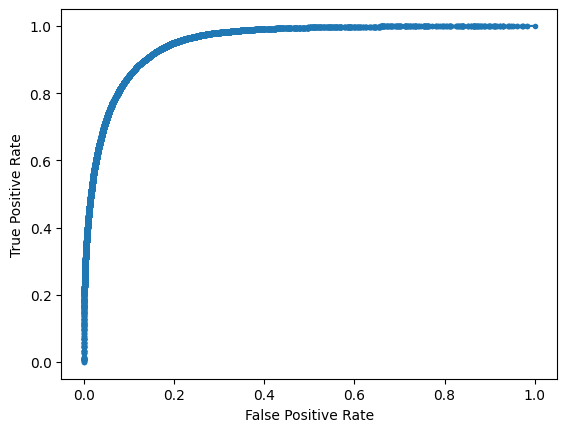

In [17]:

# Predict from XGBoost Classifier
y_pred = xg_cl.predict(X_test)
y_pred_proba = xg_cl.predict_proba(X_test)

# Generate Accuracy, ROC and Amex Score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

df_y_pred_proba = pd.DataFrame({'prediction': y_pred_proba[:,1], 'customer_id': y_test.index}).set_index('customer_id')
amex_score = amex_metric(pd.DataFrame(y_test), df_y_pred_proba)

# Print Scores
print('Accuracy Score = %.5f, AUC = %.5f, Amex Score = %.5f' % (accuracy, roc_auc, amex_score))

# Draw ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr ,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Feature Reduction using SHAP values

100%|===================| 91469/91783 [03:45<00:00]        

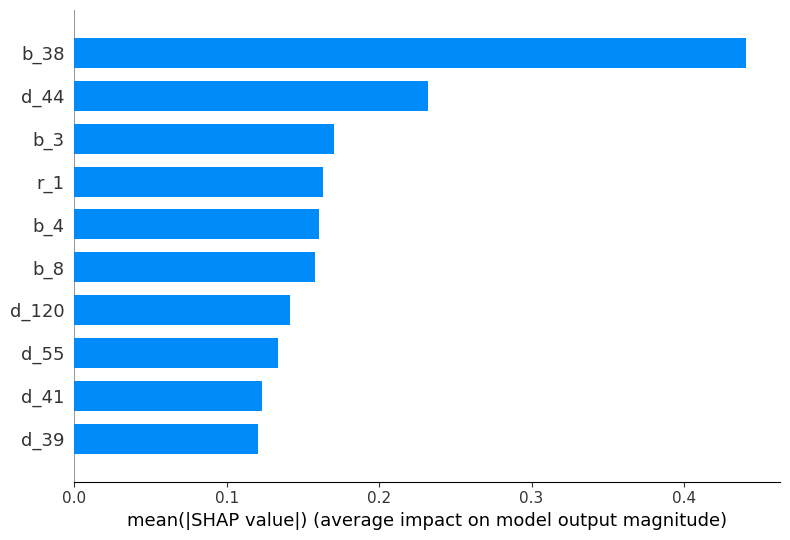

In [18]:
import shap

# Plot summary of all features
explainer = shap.TreeExplainer(xg_cl, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type='bar', max_display=10)

In [19]:
# Generate global shap values and associate with the column
global_shap_values = {k:v for k, v in sorted(zip(X_train.columns, np.abs(shap_values).mean(0)), reverse=False, key=lambda value: value[1])}
print(global_shap_values)

{'r_21': 0.0, 'r_18': 0.0, 'r_23': 0.0, 'r_22': 0.0, 'r_25': 0.0, 'd_94': 0.0, 'r_28': 0.0, 'd_109': 0.0, 'b_32': 0.0, 'd_116': 0.0, 'd_87': 8.542961103846181e-06, 'r_15': 1.4825964824512889e-05, 'd_92': 3.656777404461432e-05, 'r_24': 6.184637772492819e-05, 'd_140': 9.989993876142455e-05, 'd_137': 0.0001000392945145694, 's_20': 0.00010973677351795568, 'r_17': 0.00023756538357286937, 'r_20': 0.0003621945996702524, 'd_91': 0.0003786899220062316, 'r_4': 0.00041511098225840276, 'd_143': 0.00046906766790382154, 'b_33': 0.0005361242168135887, 'd_139': 0.0005376723934563617, 'r_19': 0.0005572371271178325, 'd_93': 0.0006712235299030031, 'd_79': 0.0012047761318713104, 'd_107': 0.002250204723313333, 'd_113': 0.0022910544559151588, 'd_141': 0.002538859870227838, 'd_111': 0.002648968104123622, 'd_125': 0.002662868949964884, 'b_41': 0.0028343393381753106, 'd_129': 0.0028410236033112823, 'd_89': 0.0030119321895317104, 'd_122': 0.0030914202512840206, 'b_31': 0.0031418403179028203, 's_11': 0.003416373

In [20]:
cols_to_remove = []

# Initialize with scores from all columns
original_accuracy, original_roc_auc, original_amex_score = accuracy, roc_auc, amex_score
max_accuracy, max_roc_auc, max_amex_score = original_accuracy, original_roc_auc, original_amex_score

# Train/Test dropping one feature at a time
i = 0
for col, _ in global_shap_values.items():
    i += 1

    X_train_reduced = X_train.drop(columns=cols_to_remove + [col])
    X_test_reduced = X_test.drop(columns=cols_to_remove + [col])

    # Model
    xg_cl_reduced = xg.XGBClassifier(objective='binary:logistic', tree_method='hist', seed=2303, **best_params)
    xg_cl_reduced.fit(X_train_reduced, y_train)

    y_pred_reduced = xg_cl_reduced.predict(X_test_reduced)
    y_pred_proba_reduced = xg_cl_reduced.predict_proba(X_test_reduced)

    # Calculate scores for this iteration
    accuracy = accuracy_score(y_test, y_pred_reduced)
    roc_auc = roc_auc_score(y_test, y_pred_proba_reduced[:, 1])
    df_y_pred_proba = pd.DataFrame({'prediction': y_pred_proba_reduced[:,1], 'customer_id': y_test.index}).set_index('customer_id')
    amex_score = amex_metric(pd.DataFrame(y_test), df_y_pred_proba)

    print('-------------------------------Iteration %d------------------------' % i)
    print('Cols Dropped: ', cols_to_remove + [col])

    diff = accuracy - max_accuracy
    percent_diff = diff / max_accuracy
    print('Max Accuracy: %.5f, Current Accuracy: %.5f, Difference: %.5f, Percentage Diff: %.5f' % (
        max_accuracy, accuracy, diff, percent_diff))
    max_accuracy = max(max_accuracy, accuracy)

    diff = roc_auc - max_roc_auc
    percent_diff = diff / max_roc_auc
    print('Max ROC AUC: %.5f, Current ROC AUC: %.5f, Difference: %.5f, Percentage Diff: %.5f' % (
        max_roc_auc, roc_auc, diff, percent_diff))
    max_roc_auc = max(max_roc_auc, roc_auc)

    diff = amex_score - max_amex_score
    percent_diff = diff / max_amex_score
    print('Max Amex Score: %.5f, Current Amex Score: %.5f, Difference: %.5f, Percentage Diff: %.5f' % (
        max_amex_score, amex_score, diff, percent_diff))
    max_amex_score = max(max_amex_score, amex_score)

    # If the accuracy increases after dropping the column
    # then drop the column
    if diff <= -0.003:
        break

    cols_to_remove.append(col)

-------------------------------Iteration 1------------------------
Cols Dropped:  ['r_21']
Max Accuracy: 0.89317, Current Accuracy: 0.89192, Difference: -0.00125, Percentage Diff: -0.00140
Max ROC AUC: 0.95217, Current ROC AUC: 0.95193, Difference: -0.00024, Percentage Diff: -0.00025
Max Amex Score: 0.76129, Current Amex Score: 0.76002, Difference: -0.00127, Percentage Diff: -0.00167
-------------------------------Iteration 2------------------------
Cols Dropped:  ['r_21', 'r_18']
Max Accuracy: 0.89317, Current Accuracy: 0.89235, Difference: -0.00082, Percentage Diff: -0.00091
Max ROC AUC: 0.95217, Current ROC AUC: 0.95204, Difference: -0.00013, Percentage Diff: -0.00014
Max Amex Score: 0.76129, Current Amex Score: 0.76124, Difference: -0.00005, Percentage Diff: -0.00006
-------------------------------Iteration 3------------------------
Cols Dropped:  ['r_21', 'r_18', 'r_23']
Max Accuracy: 0.89317, Current Accuracy: 0.89276, Difference: -0.00041, Percentage Diff: -0.00046
Max ROC AUC: 

In [21]:
# Re-train the model used for prediction (including the last column from the iteration)
print('Final cols Dropped: ', cols_to_remove)
X_train_reduced = X_train.drop(columns=cols_to_remove)
X_test_reduced = X_test.drop(columns=cols_to_remove)

print(f'The final shape of training data {X_train_reduced.shape}')

xg_cl_reduced = xg.XGBClassifier(objective='binary:logistic', tree_method='gpu_hist', seed=2303, **best_params)
xg_cl_reduced.fit(X_train_reduced, y_train)

Final cols Dropped:  ['r_21', 'r_18', 'r_23', 'r_22', 'r_25', 'd_94', 'r_28', 'd_109', 'b_32', 'd_116', 'd_87']
The final shape of training data (367130, 159)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=110, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=2303, ...)

In [22]:
y_pred_reduced = xg_cl_reduced.predict(X_test_reduced)
y_pred_proba_reduced = xg_cl_reduced.predict_proba(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred_reduced)
roc_auc = roc_auc_score(y_test, y_pred_proba_reduced[:, 1])
df_y_pred_proba = pd.DataFrame(
    {'prediction': y_pred_proba_reduced[:, 1], 'customer_id': y_test.index}).set_index('customer_id')
amex_score = amex_metric(pd.DataFrame(y_test), df_y_pred_proba)
print('Accuracy Score = %.5f, AUC = %.5f, Amex Score = %.5f' % (accuracy, roc_auc, amex_score))

Accuracy Score = 0.89277, AUC = 0.95208, Amex Score = 0.76019


In [23]:
# Some cleanup before test
# del (X_train, X_test, y_train, y_test, X_train_reduced)

In [24]:
def execute_model(df):
    # Just add extra columns with 0 value so that pipeline does not fail --> these are the extra columns that we had in the training data
    extra_cols = ['target']

    # Concatenate the dataframe of extra columns with the dataframe of the test data
    df = pd.concat([
        df,
        pd.DataFrame(np.zeros((df.shape[0], len(extra_cols))), columns=extra_cols)
    ], axis=1)

    # Use the pipeline to transform (this will drop s_2 and make customer_id index)
    X = pipeline.transform(df)

    # Drop target & the insignificant variables found during the training of XGBoost model
    X.drop(columns=['target'] + cols_to_remove, inplace=True)

    y_proba = xg_cl_reduced.predict_proba(X)
    
    return pd.DataFrame({
        'customer_id': X.index,
        'prediction': y_proba[:,1]
    })

In [25]:
df_test = pd.read_parquet('./data/test.parquet')
df_test.columns= df_test.columns.str.lower()
predictions = execute_model(df_test)

In [26]:
predictions.to_csv('./ignore/final/xgboost_shap/first_last_diff_stmt_1.csv', index=False)